In [44]:
import json 
import os 
import ast
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


In [20]:
filename = 'results/tool-calling-with-subtasks-check-none-0.1_range_0--1_user-none-llm_0714135412.json'
results = json.load(open(filename))

In [39]:
analysis = {}
for j in range(len(results)-1):
    result = results[j]
    print(j, result['task_id'])
    id = result['task_id']
    reward = result['reward']
    original_subtasks = len(ast.literal_eval(result['traj'][4]['content'].split('Subtasks solved: ')[1].strip()))
    subtasks_unsolved_before_last_step = ast.literal_eval(result['traj'][-2]['content'].split('Subtasks solved: ')[1].strip())
    subtasks_unsolved_after_last_step = 0
    for i in range(len(subtasks_unsolved_before_last_step)):
        if not subtasks_unsolved_before_last_step[i]:
            subtasks_unsolved_after_last_step += 1

    analysis[id] = {'reward': reward, 'subtasks_unsolved': subtasks_unsolved_after_last_step, 'original_subtasks': original_subtasks}

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
61 61
62 62
63 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78
79 79
80 80
81 81
82 82
83 83
84 84
85 85
86 86
87 87
88 88
89 89


In [36]:
analysis

{0: {'reward': 1.0, 'subtasks_unsolved': 1, 'original_subtasks': 3},
 1: {'reward': 1.0, 'subtasks_unsolved': 2, 'original_subtasks': 5},
 2: {'reward': 0.0, 'subtasks_unsolved': 0, 'original_subtasks': 4},
 3: {'reward': 0.0, 'subtasks_unsolved': 0, 'original_subtasks': 2},
 4: {'reward': 0.0, 'subtasks_unsolved': 0, 'original_subtasks': 3},
 5: {'reward': 1.0, 'subtasks_unsolved': 3, 'original_subtasks': 3},
 6: {'reward': 1.0, 'subtasks_unsolved': 2, 'original_subtasks': 4},
 7: {'reward': 1.0, 'subtasks_unsolved': 3, 'original_subtasks': 6},
 8: {'reward': 1.0, 'subtasks_unsolved': 2, 'original_subtasks': 3},
 9: {'reward': 1.0, 'subtasks_unsolved': 2, 'original_subtasks': 3},
 10: {'reward': 1.0, 'subtasks_unsolved': 5, 'original_subtasks': 5},
 11: {'reward': 1.0, 'subtasks_unsolved': 0, 'original_subtasks': 5},
 12: {'reward': 1.0, 'subtasks_unsolved': 2, 'original_subtasks': 5},
 13: {'reward': 1.0, 'subtasks_unsolved': 2, 'original_subtasks': 5},
 14: {'reward': 1.0, 'subtasks

In [33]:
data = analysis

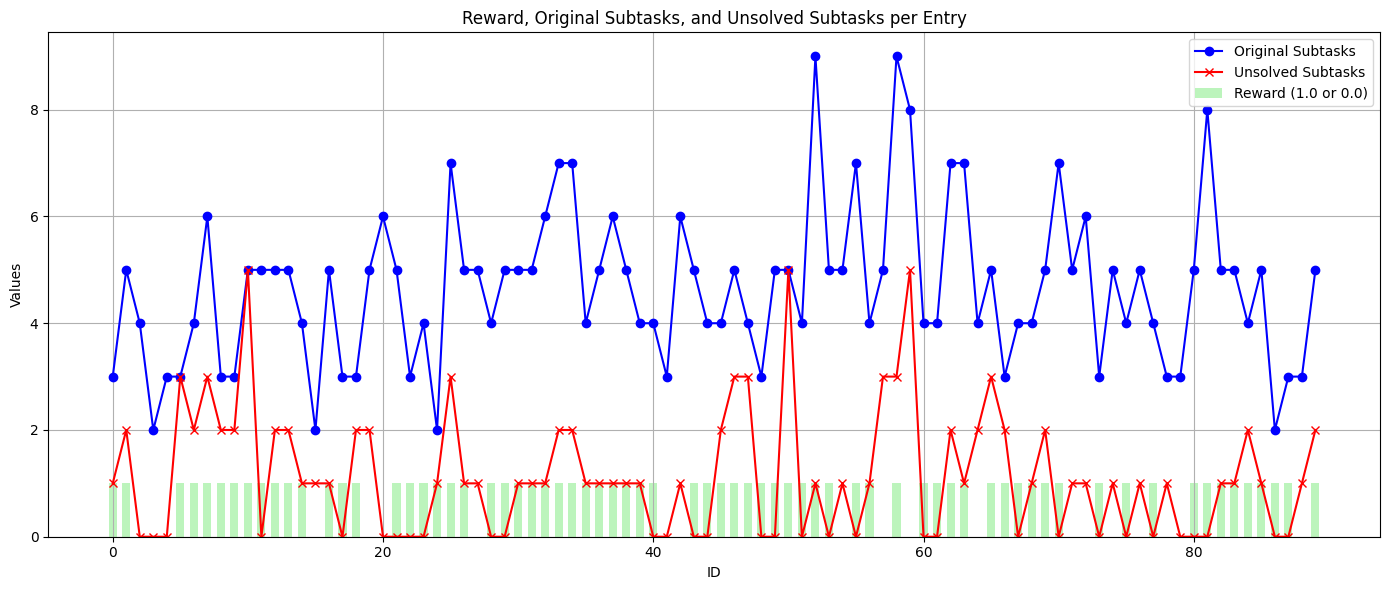

In [34]:
sorted_items = sorted(data.items())

ids = []
rewards = []
original_subtasks = []
unsolved_subtasks = []

for idx, info in sorted_items:
    ids.append(idx)
    rewards.append(info['reward'])
    original_subtasks.append(info['original_subtasks'])
    unsolved_subtasks.append(info['subtasks_unsolved'])

# Plot
plt.figure(figsize=(14, 6))

# Bar plot for reward
plt.bar(ids, rewards, color='lightgreen', label='Reward (1.0 or 0.0)', width=0.6, alpha=0.6)

# Line plots for subtasks
plt.plot(ids, original_subtasks, color='blue', marker='o', label='Original Subtasks')
plt.plot(ids, unsolved_subtasks, color='red', marker='x', label='Unsolved Subtasks')

# Labels and formatting
plt.xlabel('ID')
plt.ylabel('Values')
plt.title('Reward, Original Subtasks, and Unsolved Subtasks per Entry')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\t-avalsingh\AppData\Local\Temp\ipykernel_30396\3479596787.py:33: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\t-avalsingh\AppData\Local\Temp\ipykernel_30396\3479596787.py:33: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\t-avalsingh\AppData\Local\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\t-avalsingh\AppData\Local\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


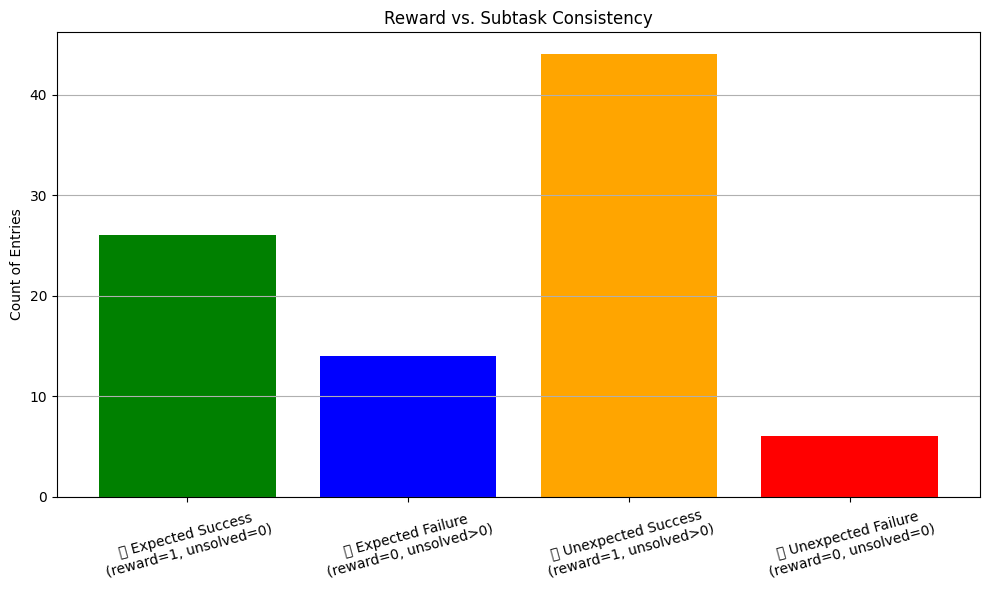

In [40]:
expected_success = 0
expected_failure = 0
unexpected_success = 0
unexpected_failure = 0

for idx, info in data.items():
    reward = info['reward']
    unsolved = info['subtasks_unsolved']
    
    if reward == 1.0 and unsolved == 0:
        expected_success += 1
    elif reward == 0.0 and unsolved > 0:
        expected_failure += 1
    elif reward == 1.0 and unsolved > 0:
        unexpected_success += 1
    elif reward == 0.0 and unsolved == 0:
        unexpected_failure += 1

# Bar chart
labels = ['✅ Expected Success\n(reward=1, unsolved=0)',
          '✅ Expected Failure\n(reward=0, unsolved>0)',
          '❌ Unexpected Success\n(reward=1, unsolved>0)',
          '❌ Unexpected Failure\n(reward=0, unsolved=0)']
counts = [expected_success, expected_failure, unexpected_success, unexpected_failure]

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color=['green', 'blue', 'orange', 'red'])
plt.title('Reward vs. Subtask Consistency')
plt.ylabel('Count of Entries')
plt.xticks(rotation=15)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

C:\Users\t-avalsingh\AppData\Local\Temp\ipykernel_30396\2657698940.py:50: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\t-avalsingh\AppData\Local\Temp\ipykernel_30396\2657698940.py:50: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\t-avalsingh\AppData\Local\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\t-avalsingh\AppData\Local\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


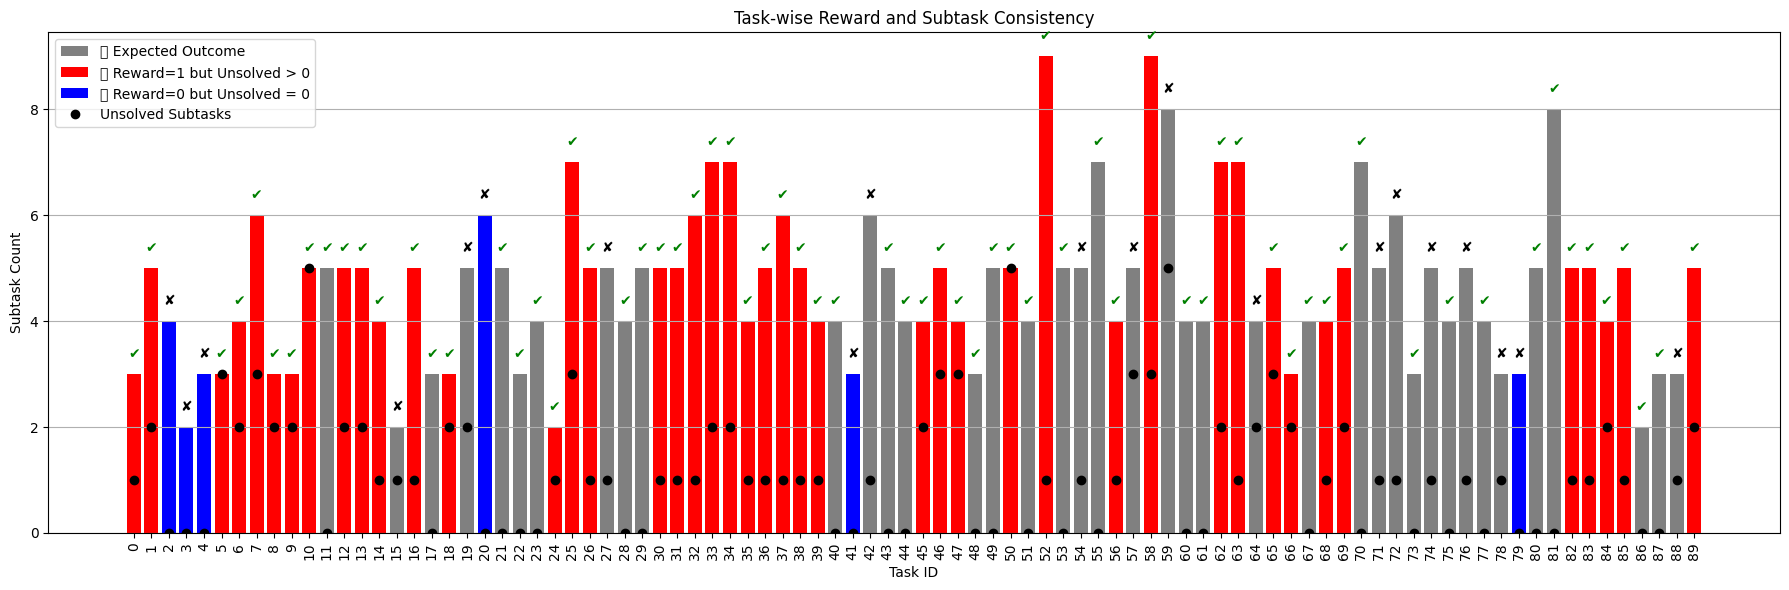

In [48]:
task_ids = sorted(data.keys())
bar_heights = []
bar_colors = []
unsolved_subtasks = []

for task_id in task_ids:
    info = data[task_id]
    reward = info['reward']
    unsolved = info['subtasks_unsolved']
    original = info['original_subtasks']

    bar_heights.append(original)
    unsolved_subtasks.append(unsolved)

    if reward == 1.0 and unsolved > 0:
        bar_colors.append('red')     # ❌ Rewarded despite unsolved
    elif reward == 0.0 and unsolved == 0:
        bar_colors.append('blue')    # ❌ Not rewarded despite solving everything
    else:
        bar_colors.append('gray')    # ✅ Expected behavior

# Plot
plt.figure(figsize=(18, 6))
plt.bar(task_ids, bar_heights, color=bar_colors, label='Original Subtasks')
plt.scatter(task_ids, unsolved_subtasks, color='black', label='Unsolved Subtasks', zorder=3)

# X-axis: Task IDs as labels
plt.xticks(task_ids, rotation=90)

# Add legend
legend_elements = [
    Patch(facecolor='gray', label='✅ Expected Outcome'),
    Patch(facecolor='red', label='❌ Reward=1 but Unsolved > 0'),
    Patch(facecolor='blue', label='❌ Reward=0 but Unsolved = 0'),
    plt.Line2D([0], [0], marker='o', color='black', label='Unsolved Subtasks', linestyle='None')
]

for i, (task_id, r) in enumerate(zip(task_ids, rewards)):
    color = 'green' if r == 1.0 else 'black'
    marker = '✔' if r == 1.0 else '✘'
    plt.text(task_id, bar_heights[i] + 0.3, marker, color=color, ha='center', fontsize=10)
    
plt.legend(handles=legend_elements)

# Labels and formatting
plt.xlabel('Task ID')
plt.ylabel('Subtask Count')
plt.title('Task-wise Reward and Subtask Consistency')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()